In [43]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [4]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_vs_baseline_across_vhpc'

In [5]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [6]:
from matplotlib.lines import Line2D
def add_significance(ax, array1, array2, x1, x2, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001)):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
    ax.add_line(line)
    ax.text(np.mean([x1, x2]), y+1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4)
    return sig_value, p

In [7]:
def sig_vs_chance(ax, array1, chance, x1, y1, loops=15, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),colors='k'):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        p = sig_func(subtracted)[-1]
        sig_value = sig_func(subtracted)[0]
    elif sig_func is ttest:
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        p = sig_func(array1,chance)[-1]
        sig_value = sig_func(array1,chance)[0]
    ax.text(x1, y1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4, color=colors)
    return sig_value, p

In [8]:
expo_animals = '94', '96', '98', '99', '100', '104', 'c18m9', 'vNAc7'
pre_animals =  '94', '96', '98', '99', '100', '104', 'c18m9', 'vNAc7'
post_animals = '94', '96', '98', '99', '100', '104', 'c18m9', 'vNAc7'
post_hiatus_animals = '94', '96', '98', '99', '100', '104', 'c18m9', 'vNAc7'
all_animals = '94', '96', '98', '99', '100', '104', 'c18m9', 'vNAc7'

In [9]:
delta_t05s = 0.5
t_start05s = -5.5 
t_stop05s = 10.5

delta_t1s = 1
t_start1s = -5 
t_stop1s  = 11 

In [10]:
sessions = 'expo','pre','post','post_hiatus'
#only going to analyze .5s and 1s bins here to save time.
bins = ['05s','1s']
bin_ranges=[]
for tb in bins:
    if tb == '05s':
        div=0.5
    else:
        div=tb[:-1]
            #print range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
    #for t in range(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div)))):
    bin_ranges.append(int(eval("(t_stop%s-t_start%s)/%s"%(tb,tb,div))))
print bin_ranges

[32, 16]


In [11]:
CR_comparisons = [['pre','post'],['pre','post_hiatus'],['post','post_hiatus']] #exclude expo session, since did not cellreg this

In [12]:
#get patterns of cells registered across 2 sessions

for tb in bins:
    for cr in CR_comparisons:
        exec("cellreg_patterns_%s_%s_reg_w_%s = dict(zip(all_animals, [ut.load_variable('patterns_evs_reg_%s_%s_%s',\
                                                               '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                      for ani in all_animals]))"%(tb,cr[0],cr[1],tb,cr[0],cr[1]))
        exec("cellreg_patterns_%s_%s_reg_w_%s = dict(zip(all_animals, [ut.load_variable('patterns_evs_reg_%s_%s_%s',\
                                                               '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                      for ani in all_animals]))"%(tb,cr[1],cr[0],tb,cr[1],cr[0]))
for sess in sessions:
    exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels_%s',\
                                                             '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                      for ani in %s_animals]))"%(sess,sess,sess,sess))

In [16]:
#get patterns of cells registered across all 3 sessions

for tb in bins:
    for sess in sessions[1:]: #exclude expo, cuz didn't register with that session
        exec("cellreg_patterns_%s_%s_reg_w_all = dict(zip(all_animals, [ut.load_variable('patterns_evs_reg_%s_%s_all',\
                                                               '../%%s/notebooks/autorestore/patterns_time_bins/'%%ani)\
                                                      for ani in all_animals]))"%(tb,sess,tb,sess))

In [17]:
tot_cells_pre_vs_post = 0
tot_cells_pre_vs_post_hiatus = 0
tot_cells_post_vs_post_hiatus = 0
for key in cellreg_patterns_1s_pre_reg_w_post:
    tot_cells_pre_vs_post = tot_cells_pre_vs_post + np.shape(cellreg_patterns_1s_pre_reg_w_post[key])[-1]
for key in cellreg_patterns_1s_pre_reg_w_post:
    tot_cells_pre_vs_post_hiatus = tot_cells_pre_vs_post_hiatus + np.shape(cellreg_patterns_1s_pre_reg_w_post_hiatus[key])[-1]
for key in cellreg_patterns_1s_pre_reg_w_post:
    tot_cells_post_vs_post_hiatus = tot_cells_post_vs_post_hiatus + np.shape(cellreg_patterns_1s_post_reg_w_post_hiatus[key])[-1]
print tot_cells_pre_vs_post
print tot_cells_pre_vs_post_hiatus
print tot_cells_post_vs_post_hiatus
min_cells = min(tot_cells_pre_vs_post,tot_cells_pre_vs_post_hiatus,tot_cells_post_vs_post_hiatus)
print "2 session min cells =",min_cells

min_cells_reg_all = 0
for key in cellreg_patterns_1s_pre_reg_w_all:
    min_cells_reg_all=min_cells_reg_all+np.shape(cellreg_patterns_1s_pre_reg_w_all[key])[-1]
print "all sess min cells =",min_cells_reg_all

128
150
163
2 session min cells = 128
all sess min cells = 102


In [18]:
#rearrange dictionary/list structure
for cr in CR_comparisons:
    for tb,i in zip(bins,range(len(bins))):
        for t in range(bin_ranges[i]):
            exec('cellreg_patterns_%s_%s_reg_w_%s_%s = {}'%(tb,cr[0],cr[1],t))
            exec('cellreg_patterns_%s_%s_reg_w_%s_%s = {}'%(tb,cr[1],cr[0],t))
            for ani in all_animals:
                try:
                    exec("cellreg_patterns_%s_%s_reg_w_%s_%s['%s'] = cellreg_patterns_%s_%s_reg_w_%s['%s'][%s]"%(tb,cr[0],cr[1],t,ani,tb,cr[0],cr[1],ani,t))
                    exec("cellreg_patterns_%s_%s_reg_w_%s_%s['%s'] = cellreg_patterns_%s_%s_reg_w_%s['%s'][%s]"%(tb,cr[1],cr[0],t,ani,tb,cr[1],cr[0],ani,t))
                except:
                    print 'NOPE',cr, tb, ani
                    continue

In [19]:
#rearrange dictionary/list structure
for sess in sessions[1:]:
    for tb,i in zip(bins,range(len(bins))):
        for t in range(bin_ranges[i]):
            exec('cellreg_patterns_%s_%s_reg_w_all_%s = {}'%(tb,sess,t))
            for ani in all_animals:
                try:
                    exec("cellreg_patterns_%s_%s_reg_w_all_%s['%s'] = cellreg_patterns_%s_%s_reg_w_all['%s'][%s]"%(tb,sess,t,ani,tb,sess,ani,t))
                except:
                    print 'NOPE',sess, tb, ani
                    continue

#set downsampling parameter to:
#max_cells = all cells
#intraregion_min = downsample to the comparison with fewest cells within the same hippo region
#interregion_min = downsample to the comparison with fewest cells, considering both hippo regions
#gmin = the global minimum (pretty much corresponds to interregion_min)

downsample = 'gmin'

if downsample == 'max_cells':
    n_cells = None #will use all registered cells
if downsample == 'intraregion_min':
    n_cells = ut.load_variable('n_cells_across_min_vhpc', '../notebooks/autorestore/n_cells/')
if downsample == 'interregion_min':
    n_cells = ut.load_variable('n_cells_across_min_overall', '../notebooks/autorestore/n_cells/')
if downsample == 'gmin':
    n_cells = ut.load_variable('n_cells_gmin', '../notebooks/autorestore/n_cells/')
if downsample == 200:
    n_cells = 200
    
print "# of cells =",n_cells

### need to take data from a single trial type and duplicate it, assigning it a new label/class. Then use the baseline time bin of the dataset with this new label and decode against all time bins from original dataset

In [20]:
#make a new label array, assigning new labels for each trial type
relabel_baselines = {1:10,2:20,3:30,4:40}

for sess in sessions:
    for tb in bins:
        try:
            exec("labels_baselines_%s = {}"%sess)
            for ani in eval("%s_animals"%sess):
                exec("labels_baselines_%s[ani] = np.r_[[relabel_baselines[l] for l in labels_%s[ani]]]"%(sess,sess))
        except:
            print 'nope %s %s'%(sess,tb)

In [21]:
#concatenate new label array to original
for sess in sessions:
    for tb in bins:
        try:
            exec("labels_%s_w_baselines = {}"%sess)
            for ani in eval("labels_%s.keys()"%sess):
                exec("labels_%s_w_baselines[ani] = np.concatenate((labels_%s[ani],labels_baselines_%s[ani]))"%(sess,sess,sess))
        except:
            print 'nope %s %s'%(sess,tb)

In [22]:
# concatenate patterns from one time bin with itself
bases = [4,1,0] #time bins for each tb delta to use for baseline (start at 3.5s, 4s, 4.5s, 4s)
for tb,ind,base in zip(bins,range(len(bins)),bases):
    for cr in CR_comparisons:
        for t in range(bin_ranges[ind]):
            try:
                exec('cr_patterns_%s_%s_reg_w_%s_%s_w_baselines = {}'%(tb,cr[0],cr[1],t))
                exec('cr_patterns_%s_%s_reg_w_%s_%s_w_baselines = {}'%(tb,cr[1],cr[0],t))
                for ani in eval('labels_%s.keys()'%(cr[0])):
                    exec("cr_patterns_%s_%s_reg_w_%s_%s_w_baselines[ani] = np.concatenate((cellreg_patterns_%s_%s_reg_w_%s_%s[ani],\
                    cellreg_patterns_%s_%s_reg_w_%s_%s[ani]))"%(tb,cr[0],cr[1],t,tb,cr[0],cr[1],t,tb,cr[0],cr[1],base))
                    exec("cr_patterns_%s_%s_reg_w_%s_%s_w_baselines[ani] = np.concatenate((cellreg_patterns_%s_%s_reg_w_%s_%s[ani],\
                    cellreg_patterns_%s_%s_reg_w_%s_%s[ani]))"%(tb,cr[1],cr[0],t,tb,cr[1],cr[0],t,tb,cr[1],cr[0],base))
            except:
                    print 'NOPE', sess, ani, tb

In [23]:
# concatenate patterns from one time bin with itself
bases = [4,1,0] #time bins for each tb delta to use for baseline (start at 3.5s, 4s, 4.5s, 4s)
for tb,ind,base in zip(bins,range(len(bins)),bases):
    for sess in sessions[1:]:
        for t in range(bin_ranges[ind]):
            try:
                exec('cr_patterns_%s_%s_reg_w_all_%s_w_baselines = {}'%(tb,sess,t))
                for ani in eval('labels_%s.keys()'%(sess)):
                    exec("cr_patterns_%s_%s_reg_w_all_%s_w_baselines[ani] = np.concatenate((cellreg_patterns_%s_%s_reg_w_all_%s[ani],\
                    cellreg_patterns_%s_%s_reg_w_all_%s[ani]))"%(tb,sess,t,tb,sess,t,tb,sess,base))
            except:
                    print 'NOPE', sess, ani, tb

In [33]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def combine_train_test_patterns_across_tbs(patterns_train,labels_train,patterns_test,labels_test, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns_train.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels_train[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns_train.copy()
    labels_t = labels_train.copy()
    for ani in patterns_train.keys():
        patterns_t[ani] = patterns_train[ani][which_train[ani]]
        labels_t[ani] = labels_train[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns_test.copy()
        labels_T = labels_test.copy()
        for ani in patterns_test.keys():
            patterns_T[ani] = patterns_test[ani][which_test[ani]]
            labels_T[ani] = labels_test[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
    
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None)

def do_test_across_tbs(patterns_train,labels_train,patterns_test,labels_test, **args):
    x, y, xT, yT = combine_train_test_patterns_across_tbs(patterns_train,labels_train,patterns_test,labels_test, train_test_split=0.5, **args)
    decoder.fit(x, y)
    return decoder.score(xT, yT)

In [34]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')

In [35]:
CR_comp_labels = 'pre_vs_post','pre_vs_post_hiatus','post_vs_post_hiatus'

In [36]:
%%time
#decode across time bins w/in a session (using cells registered across 2 sessions...so, yes, will have two results for each sesion,
 #based on which other session its cells were registered with)
n_loops=15
classes = [1,10],[2,20],[3,30],[4,40]
comparison_labels='CS1','CS2','CS3','CS4'
for cr,cr_la in zip(CR_comparisons, CR_comp_labels):
    print cr_la,
    for cl,comp_la in zip(classes,comparison_labels):
        print comp_la,
        for tb,i in zip(bins,range(len(bins))):
            print tb,
            for t in range(bin_ranges[i]): # number of time bins
                for c in range(bin_ranges[i]):
                    print ".",
                    #try:
                    exec("baseline_scores_%s_%s_reg_w_%s_%s_tb%svs%s = np.r_[[do_test_across_tbs(cr_patterns_%s_%s_reg_w_%s_%s_w_baselines,\
                            labels_%s_w_baselines,cr_patterns_%s_%s_reg_w_%s_%s_w_baselines,labels_%s_w_baselines,classes=cl,\
                            n_cells=min_cells,relabel=None) for n in range(n_loops)]]"%(tb,cr[0],cr[1],comp_la,t,c,tb,cr[0],cr[1],t,cr[0],
                                                                                  tb,cr[0],cr[1],c,cr[0]))
                    exec("baseline_scores_%s_%s_reg_w_%s_%s_tb%svs%s = np.r_[[do_test_across_tbs(cr_patterns_%s_%s_reg_w_%s_%s_w_baselines,\
                            labels_%s_w_baselines,cr_patterns_%s_%s_reg_w_%s_%s_w_baselines,labels_%s_w_baselines,classes=cl,\
                            n_cells=min_cells,relabel=None) for n in range(n_loops)]]"%(tb,cr[1],cr[0],comp_la,t,c,tb,cr[1],cr[0],t,cr[1],
                                                                                  tb,cr[1],cr[0],c,cr[1]))
                    #except:
                    #    print 'NOPE',

pre_vs_post CS1 05s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [37]:
%%time
#decode across time bins w/in a session (using cells registered across all 3 sessions)
n_loops=15
classes = [1,10],[2,20],[3,30],[4,40]
comparison_labels='CS1','CS2','CS3','CS4'
for sess in sessions[1:]: #again, excluding expo from analysis due to no cell registration from this session
    print sess,
    for cl,comp_la in zip(classes,comparison_labels):
        print comp_la,
        for tb,i in zip(bins,range(len(bins))):
            print tb,
            for t in range(bin_ranges[i]): # number of time bins
                for c in range(bin_ranges[i]):
                    print ".",
                    #try:
                    exec("baseline_scores_%s_%s_reg_w_all_%s_tb%svs%s = np.r_[[do_test_across_tbs(cr_patterns_%s_%s_reg_w_all_%s_w_baselines,\
                            labels_%s_w_baselines,cr_patterns_%s_%s_reg_w_all_%s_w_baselines,labels_%s_w_baselines,classes=cl,\
                            n_cells=102,relabel=None) for n in range(n_loops)]]"%(tb,sess,comp_la,t,c,tb,sess,t,sess,
                                                                                  tb,sess,c,sess))
                    #except:
                    #    print 'NOPE',

pre CS1 05s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [46]:
np.mean(baseline_scores_1s_post_reg_w_all_CS1_tb7vs7)

0.77166666666666672

### now decode across sessions. need to find trials that match labels for each session (ie, don't use trial positions extracted from one session and apply those to other session (whose trial order may differ))

In [38]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def combine_train_test_patterns_across_tbs_and_sess(patterns_train,labels_train,patterns_test,labels_test, train_test_split=0.5, classes=range(0,4), n_cells=None,
                                relabel=None, relabel_test=None):

    which_train = {}
    which_test = {}
    for ani in patterns_train.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                # get trials that match labels for both sessions you're comparing
                wt = np.random.permutation(np.where(labels_train[ani]==l)[0])
                wT = np.random.permutation(np.where(labels_test[ani]==l)[0])
                #we could use all trials for both sessions, but to keep trial # consistent with w/in sess decoding, just use half of available trials
                which_trains.append(wt[int(len(wt)*train_test_split):])
                which_tests.append(wT[int(len(wT)*train_test_split):])
            #if l>=10: #make sure you train and test on different trials for the baseline patterns (because you're using the same pool for training and testing)
            #    wt = np.random.permutation(np.where(labels_train[ani]==l)[0])
            #    wT = wt[:int(len(wt)*train_test_split)]
            #    which_trains.append(wt[int(len(wt)*train_test_split):])
            #    which_tests.append(wT)

        which_train[ani] = np.concatenate(which_trains)
        which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns_train.copy()
    labels_t = labels_train.copy()
    for ani in patterns_train.keys():
        patterns_t[ani] = patterns_train[ani][which_train[ani]]
        labels_t[ani] = labels_train[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns_test.copy()
        labels_T = labels_test.copy()
        for ani in patterns_test.keys():
            patterns_T[ani] = patterns_test[ani][which_test[ani]]
            labels_T[ani] = labels_test[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
    
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None)

def do_test_across_tbs_and_sess(patterns_train,labels_train,patterns_test,labels_test, **args):
    x, y, xT, yT = combine_train_test_patterns_across_tbs_and_sess(patterns_train,labels_train,patterns_test,labels_test, train_test_split=0.5, **args)
    decoder.fit(x,y)
    scores = decoder.score(xT, yT)
    decoder.fit(xT,yT)
    return np.append(scores, decoder.score(x, y))

In [39]:
%%time
#decode across time bins ACROSS sessions (using cells registered across 2 sessions)
n_loops=15
classes = [1,10],[2,20],[3,30],[4,40]
comparison_labels='CS1','CS2','CS3','CS4'
for cr,cr_la in zip(CR_comparisons, CR_comp_labels):
    print cr_la,
    for cl,comp_la in zip(classes,comparison_labels):
        print comp_la,
        for tb,i in zip(bins,range(len(bins))):
            print tb,
            for t in range(bin_ranges[i]): # number of time bins
                for c in range(bin_ranges[i]):
                    print ".",
                    #try:
                    exec("baseline_scores_%s_%svs%s_reg_w_%s_%s_tb%svs%s = np.r_[[do_test_across_tbs_and_sess(cr_patterns_%s_%s_reg_w_%s_%s_w_baselines,\
                            labels_%s_w_baselines,cr_patterns_%s_%s_reg_w_%s_%s_w_baselines,labels_%s_w_baselines,classes=cl,\
                            n_cells=128,relabel=None) for n in range(n_loops)]]"%(tb,cr[0],cr[1],cr[1],comp_la,t,c,tb,cr[0],cr[1],t,cr[0],
                                                                                  tb,cr[1],cr[0],c,cr[1]))
                    ##don't need to make variable for train/testing in opposite direction, because just do this in the fxn
                    #except:
                    #    print 'NOPE',

pre_vs_post CS1 05s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [40]:
%%time
#decode across time bins ACROSS sessions (using cells registered across all 3 sessions)
n_loops=15
classes = [1,10],[2,20],[3,30],[4,40]
comparison_labels='CS1','CS2','CS3','CS4'
for cr in CR_comparisons:
    print sess,
    for cl,comp_la in zip(classes,comparison_labels):
        print comp_la,
        for tb,i in zip(bins,range(len(bins))):
            print tb,
            for t in range(bin_ranges[i]): # number of time bins
                for c in range(bin_ranges[i]):
                    print ".",
                    #try:
                    exec("baseline_scores_%s_%svs%s_reg_w_all_%s_tb%svs%s = np.r_[[do_test_across_tbs_and_sess(cr_patterns_%s_%s_reg_w_all_%s_w_baselines,\
                            labels_%s_w_baselines,cr_patterns_%s_%s_reg_w_all_%s_w_baselines,labels_%s_w_baselines,classes=cl,\
                            n_cells=102,relabel=None) for n in range(n_loops)]]"%(tb,cr[0],cr[1],comp_la,t,c,tb,cr[0],t,cr[0],
                                                                                  tb,cr[1],c,cr[1]))
                    #except:
                    #    print 'NOPE',

post_hiatus CS1 05s . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [96]:
#make dictionary of comparisons: for each time bin condition (.5s or 1s bins) and each CS, make a dictionary for each specific
 #time bin, importing all the other time bins it was decoded with (eg, bins 6vs5,6vs6,6vs7,etc). each session comparison is a key
for comp_la in comparison_labels:
    for tb,i in zip(bins,range(len(bins))):
        for t in range(bin_ranges[i]): # number of time bins
            exec('distinct_%s_%s_%s = {}'%(tb,t,comp_la))

#across sess comparisons using cellreg'd across all 3 sessions
for comp_la in comparison_labels:
    for cr in CR_comparisons:
        for tb,i in zip(bins,range(len(bins))):
            for t in range(bin_ranges[i]): # number of time bins
                exec("distinct_%s_%s_%s['%s_%svs%s_all_%s']=[]"%(tb,t,comp_la,tb,cr[0],cr[1],comp_la))
                for c in range(bin_ranges[i]):
                    eval("distinct_%s_%s_%s['%s_%svs%s_all_%s']"%(tb,t,comp_la,tb,cr[0],cr[1],comp_la)).insert(c,
                        eval("np.mean(baseline_scores_%s_%svs%s_reg_w_all_%s_tb%svs%s,1)"%(tb,cr[0],cr[1],comp_la,t,c)))
                    #since did both "forward and backward" decoding aross sessions (ie, train on pre, test on post and vice-versa
                    #need to take the mean of both directions to get a 1D array)

#now incorporate within-sess decoding scores
for comp_la in comparison_labels:
    for sess in sessions[1:]:
        for tb,i in zip(bins,range(len(bins))):
            for t in range(bin_ranges[i]): # number of time bins
                exec("distinct_%s_%s_%s['%s_%s_all_%s']=[]"%(tb,t,comp_la,tb,sess,comp_la))
                for c in range(bin_ranges[i]):
                    eval("distinct_%s_%s_%s['%s_%s_all_%s']"%(tb,t,comp_la,tb,sess,comp_la)).insert(c,
                        eval("baseline_scores_%s_%s_reg_w_all_%s_tb%svs%s"%(tb,sess,comp_la,t,c)))

In [97]:
#perform wilcoxon test (nonparametric) for each decoding epoch vs chance (.5)
for comp_la in comparison_labels:
    for tb,i in zip(bins,range(len(bins))):
        for t in range(bin_ranges[i]): # number of time bins
            exec("distinct_%s_%s_%s_wilcox = {}"%(tb,t,comp_la))
            for i in eval("distinct_%s_%s_%s"%(tb,t,comp_la)):
                exec("distinct_%s_%s_%s_wilcox[i] = [[] for x in range(len(distinct_%s_%s_%s[i]))]"%(tb,t,comp_la,tb,t,comp_la)) #initialize list of lists with proper # of entries
                for r in range(len(eval("distinct_%s_%s_%s[i]"%(tb,t,comp_la)))):
                    exec("subtracted = [x-0.5 for x in distinct_%s_%s_%s[i][r]]"%(tb,t,comp_la))
                    exec("distinct_%s_%s_%s_wilcox[i][r] =  sstats.wilcoxon(subtracted[:15])"%(tb,t,comp_la))
                    exec("distinct_%s_%s_%s_wilcox[i][r] = distinct_%s_%s_%s_wilcox[i][r][-1]"%(tb,t,comp_la,tb,t,comp_la)) #only take p-values

/home/fabios/anaconda2/lib/python2.7/site-packages/scipy/stats/morestats.py:2397: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


In [100]:
#make dictionary of comparisons, this time taking mean of all loops for plotting (although could probably just do this while plotting)
for comp_la in comparison_labels:
    for tb,i in zip(bins,range(len(bins))):
        for t in range(bin_ranges[i]): # number of time bins
            exec('distinct_means_%s_%s_%s = {}'%(tb,t,comp_la))

#across sess comparisons using cellreg'd across all 3 sessions
for comp_la in comparison_labels:
    for cr in CR_comparisons:
        for tb,i in zip(bins,range(len(bins))):
            for t in range(bin_ranges[i]): # number of time bins
                exec("distinct_means_%s_%s_%s['%s_%svs%s_all_%s']=[]"%(tb,t,comp_la,tb,cr[0],cr[1],comp_la))
                for c in range(bin_ranges[i]):
                    eval("distinct_means_%s_%s_%s['%s_%svs%s_all_%s']"%(tb,t,comp_la,tb,cr[0],cr[1],comp_la)).insert(c,
                        eval("(baseline_scores_%s_%svs%s_reg_w_all_%s_tb%svs%s.mean())"%(tb,cr[0],cr[1],comp_la,t,c)))
                    #since did both "forward and backward" decoding aross sessions (ie, train on pre, test on post and vice-versa
                    #need to take the mean of both directions to get a 1D array)

#now incorporate within-sess decoding scores
for comp_la in comparison_labels:
    for sess in sessions[1:]:
        for tb,i in zip(bins,range(len(bins))):
            for t in range(bin_ranges[i]): # number of time bins
                exec("distinct_means_%s_%s_%s['%s_%s_all_%s']=[]"%(tb,t,comp_la,tb,sess,comp_la))
                for c in range(bin_ranges[i]):
                    eval("distinct_means_%s_%s_%s['%s_%s_all_%s']"%(tb,t,comp_la,tb,sess,comp_la)).insert(c,
                        eval("baseline_scores_%s_%s_reg_w_all_%s_tb%svs%s.mean()"%(tb,sess,comp_la,t,c)))            

In [106]:
for comp_la in comparison_labels:
    for tb in bins:
        exec("distinct_means_%s_%s={}"%(tb,comp_la))
        for key in eval("distinct_means_%s_0_%s"%(tb,comp_la)): #taking any time bin to get keys that are present in any time bin dictionary
            exec("distinct_means_%s_%s[key]=[]"%(tb,comp_la))
            for r in range(len(eval("distinct_means_%s_0_%s[key]"%(tb,comp_la)))):
                eval("distinct_means_%s_%s[key].append(distinct_means_%s_%s_%s[key])"%(tb,comp_la,tb,r,comp_la))
            eval("np.array([distinct_means_%s_%s[key]])"%(tb,comp_la))

In [114]:
mega_list_col1 = ['pre_all'],['prevspost_all'],['prevspost_hiatus_all']
mega_list_col2 = ['prevspost_all'],['post_all'],['postvspost_hiatus_all']
mega_list_col3 = ['prevspost_hiatus_all'],['post_hiatus_all'],['postvspost_hiatus_all']

In [125]:
#organize matrix of decoding scores
for comp_la in comparison_labels:
    for tb,i in zip(bins,range(len(bins))):
        for col in range(1,4):
            exec("mega_col_%s_%s_%s = [[0]]*bin_ranges[i]"%(col,tb,comp_la))
            for x in range(len(eval("distinct_means_%s_0_%s['%s_pre_all_%s']"%(tb,comp_la,tb,comp_la)))): #just choosing any key here
                exec("mega_col_%s_%s_%s[%s] = []"%(col,tb,comp_la,x))
                for c in range(len(mega_list_col1)):
                    for comp in eval("mega_list_col%s[%s]"%((c+1),col-1)):
                        for y in range(len(eval("distinct_means_%s_0_%s['%s_pre_all_%s']"%(tb,comp_la,tb,comp_la)))):
                            print col,x,c,comp,y,'ok',
                            eval("mega_col_%s_%s_%s[x]"%(col,tb,comp_la)).insert((bin_ranges[i]*c)+y,
                                  eval("distinct_means_%s_%s_%s['%s_%s_%s'][y]"%(tb,x,comp_la,tb,comp,comp_la)))

1 0 0 pre_all 0 ok 1 0 0 pre_all 1 ok 1 0 0 pre_all 2 ok 1 0 0 pre_all 3 ok 1 0 0 pre_all 4 ok 1 0 0 pre_all 5 ok 1 0 0 pre_all 6 ok 1 0 0 pre_all 7 ok 1 0 0 pre_all 8 ok 1 0 0 pre_all 9 ok 1 0 0 pre_all 10 ok 1 0 0 pre_all 11 ok 1 0 0 pre_all 12 ok 1 0 0 pre_all 13 ok 1 0 0 pre_all 14 ok 1 0 0 pre_all 15 ok 1 0 0 pre_all 16 ok 1 0 0 pre_all 17 ok 1 0 0 pre_all 18 ok 1 0 0 pre_all 19 ok 1 0 0 pre_all 20 ok 1 0 0 pre_all 21 ok 1 0 0 pre_all 22 ok 1 0 0 pre_all 23 ok 1 0 0 pre_all 24 ok 1 0 0 pre_all 25 ok 1 0 0 pre_all 26 ok 1 0 0 pre_all 27 ok 1 0 0 pre_all 28 ok 1 0 0 pre_all 29 ok 1 0 0 pre_all 30 ok 1 0 0 pre_all 31 ok 1 0 1 prevspost_all 0 ok 1 0 1 prevspost_all 1 ok 1 0 1 prevspost_all 2 ok 1 0 1 prevspost_all 3 ok 1 0 1 prevspost_all 4 ok 1 0 1 prevspost_all 5 ok 1 0 1 prevspost_all 6 ok 1 0 1 prevspost_all 7 ok 1 0 1 prevspost_all 8 ok 1 0 1 prevspost_all 9 ok 1 0 1 prevspost_all 10 ok 1 0 1 prevspost_all 11 ok 1 0 1 prevspost_all 12 ok 1 0 1 prevspost_all 13 ok 1 0 1 prevspost_

In [137]:
for comp_la in comparison_labels:
    for tb in bins:
        exec("mega_distinct_means_all_%s_%s = mega_col_1_%s_%s + mega_col_2_%s_%s + mega_col_3_%s_%s"%(tb,comp_la,tb,comp_la,tb,comp_la,tb,comp_la))

In [129]:
#organize matrix of p-values
for comp_la in comparison_labels:
    for tb,i in zip(bins,range(len(bins))):
        for col in range(1,4):
            exec("mega_pval_col_%s_%s_%s = [[0]]*bin_ranges[i]"%(col,tb,comp_la)) #initialize proper size list with placeholder entries
            for x in range(len(eval("distinct_%s_0_%s_wilcox['%s_pre_all_%s']"%(tb,comp_la,tb,comp_la)))): #just choosing any key here
                exec("mega_pval_col_%s_%s_%s[%s] = []"%(col,tb,comp_la,x))
                for c in range(len(mega_list_col1)):
                    for comp in eval("mega_list_col%s[%s]"%((c+1),col-1)):
                        for y in range(len(eval("distinct_%s_0_%s_wilcox['%s_pre_all_%s']"%(tb,comp_la,tb,comp_la)))):
                            print col,x,c,comp,y,'ok',
                            eval("mega_pval_col_%s_%s_%s[x]"%(col,tb,comp_la)).insert((bin_ranges[i]*c)+y,
                                  eval("distinct_%s_%s_%s_wilcox['%s_%s_%s'][y]"%(tb,x,comp_la,tb,comp,comp_la)))

1 0 0 pre_all 0 ok 1 0 0 pre_all 1 ok 1 0 0 pre_all 2 ok 1 0 0 pre_all 3 ok 1 0 0 pre_all 4 ok 1 0 0 pre_all 5 ok 1 0 0 pre_all 6 ok 1 0 0 pre_all 7 ok 1 0 0 pre_all 8 ok 1 0 0 pre_all 9 ok 1 0 0 pre_all 10 ok 1 0 0 pre_all 11 ok 1 0 0 pre_all 12 ok 1 0 0 pre_all 13 ok 1 0 0 pre_all 14 ok 1 0 0 pre_all 15 ok 1 0 0 pre_all 16 ok 1 0 0 pre_all 17 ok 1 0 0 pre_all 18 ok 1 0 0 pre_all 19 ok 1 0 0 pre_all 20 ok 1 0 0 pre_all 21 ok 1 0 0 pre_all 22 ok 1 0 0 pre_all 23 ok 1 0 0 pre_all 24 ok 1 0 0 pre_all 25 ok 1 0 0 pre_all 26 ok 1 0 0 pre_all 27 ok 1 0 0 pre_all 28 ok 1 0 0 pre_all 29 ok 1 0 0 pre_all 30 ok 1 0 0 pre_all 31 ok 1 0 1 prevspost_all 0 ok 1 0 1 prevspost_all 1 ok 1 0 1 prevspost_all 2 ok 1 0 1 prevspost_all 3 ok 1 0 1 prevspost_all 4 ok 1 0 1 prevspost_all 5 ok 1 0 1 prevspost_all 6 ok 1 0 1 prevspost_all 7 ok 1 0 1 prevspost_all 8 ok 1 0 1 prevspost_all 9 ok 1 0 1 prevspost_all 10 ok 1 0 1 prevspost_all 11 ok 1 0 1 prevspost_all 12 ok 1 0 1 prevspost_all 13 ok 1 0 1 prevspost_

In [136]:
for comp_la in comparison_labels:
    for tb in bins:
        exec("mega_distinct_pval_all_%s_%s = mega_pval_col_1_%s_%s + mega_pval_col_2_%s_%s + mega_pval_col_3_%s_%s"%(tb,comp_la,tb,comp_la,tb,comp_la,tb,comp_la))

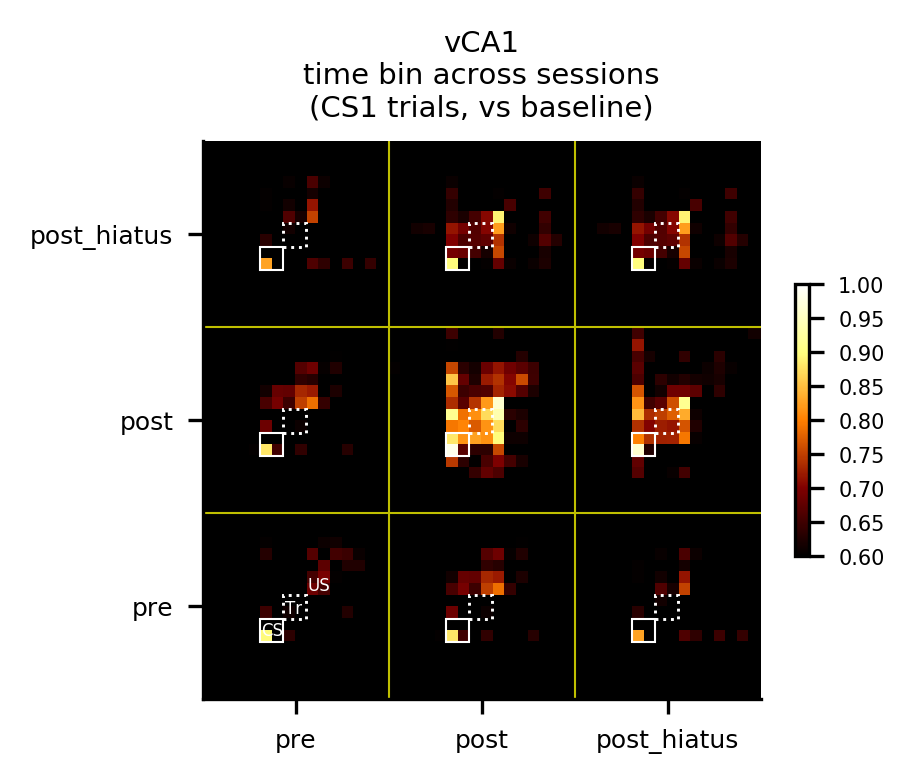

In [146]:
CS = 'CS1'
fig,ax = pl.subplots(1,figsize=(3,3))
im = ax.pcolormesh(eval("mega_distinct_means_all_1s_%s"%(CS)),vmin=0.6, vmax=1,cmap='afmhot')
pl.axis('image')
ticks = [8,24,40]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(['pre','post','post_hiatus'],fontsize=6)
ax.set_yticklabels(['pre','post','post_hiatus'],fontsize=6)
pl.hlines([16,32],-0.5,80,color='y')
pl.vlines([16,32],-0.5,80,color='y')
pl.title('vCA1\ntime bin across sessions\n(%s trials, vs baseline)'%CS)

import matplotlib.patches as patches
# Create a Rectangle patch
for i in range(5):
    CS1 = patches.Rectangle((i*16+4.9,4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    CS2 = patches.Rectangle((i*16+4.9,1*16+4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    CS3 = patches.Rectangle((i*16+4.9,2*16+4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    Tr1 = patches.Rectangle((i*16+6.9,6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
    Tr2 = patches.Rectangle((i*16+6.9,1*16+6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
    Tr3 = patches.Rectangle((i*16+6.9,2*16+6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax.add_patch(CS1)
    ax.add_patch(CS2)
    ax.add_patch(CS3)
    ax.add_patch(Tr1)
    ax.add_patch(Tr2)
    ax.add_patch(Tr3)
pl.text(5,5.45,"CS",fontsize=4, color='w')
pl.text(7.1,7.35,"Tr",fontsize=4, color='w')
pl.text(9,9.35,"US",fontsize=4, color='w')
#cax = fig.add_axes([.85, 0.86, 0.05, 0.05])
fig.colorbar(im,shrink=0.4)

fig.savefig('../figures/%s_MEGA_MATRIX_%s.pdf'%(NOTEBOOK_NAME,CS))

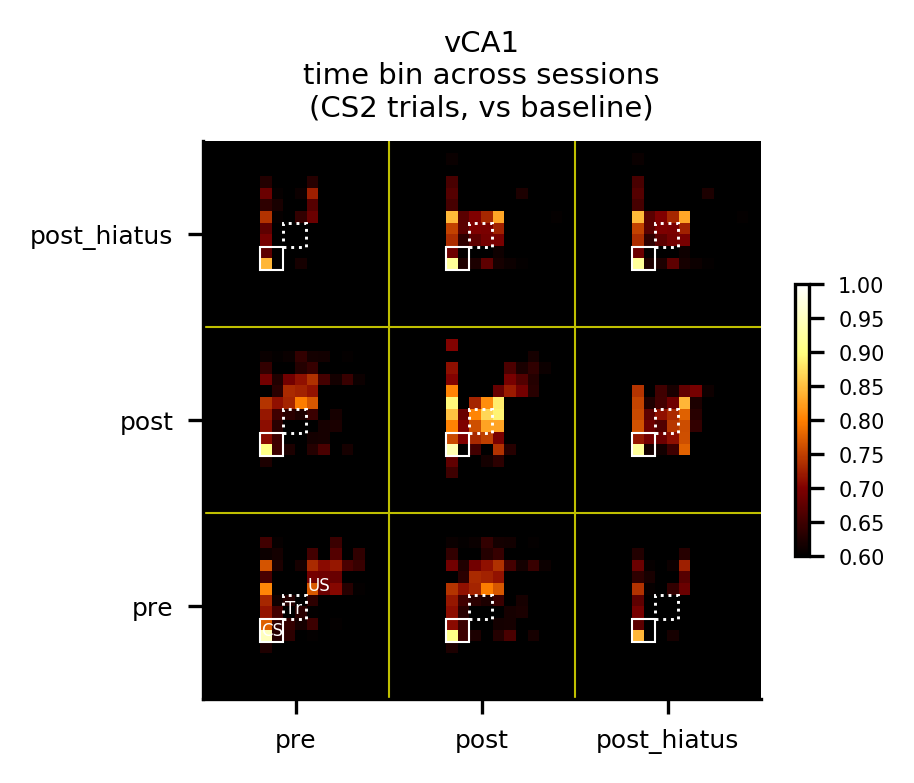

In [147]:
CS = 'CS2'
fig,ax = pl.subplots(1,figsize=(3,3))
im = ax.pcolormesh(eval("mega_distinct_means_all_1s_%s"%(CS)),vmin=0.6, vmax=1,cmap='afmhot')
pl.axis('image')
ticks = [8,24,40]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(['pre','post','post_hiatus'],fontsize=6)
ax.set_yticklabels(['pre','post','post_hiatus'],fontsize=6)
pl.hlines([16,32],-0.5,80,color='y')
pl.vlines([16,32],-0.5,80,color='y')
pl.title('vCA1\ntime bin across sessions\n(%s trials, vs baseline)'%CS)

import matplotlib.patches as patches
# Create a Rectangle patch
for i in range(5):
    CS1 = patches.Rectangle((i*16+4.9,4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    CS2 = patches.Rectangle((i*16+4.9,1*16+4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    CS3 = patches.Rectangle((i*16+4.9,2*16+4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    Tr1 = patches.Rectangle((i*16+6.9,6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
    Tr2 = patches.Rectangle((i*16+6.9,1*16+6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
    Tr3 = patches.Rectangle((i*16+6.9,2*16+6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax.add_patch(CS1)
    ax.add_patch(CS2)
    ax.add_patch(CS3)
    ax.add_patch(Tr1)
    ax.add_patch(Tr2)
    ax.add_patch(Tr3)
pl.text(5,5.45,"CS",fontsize=4, color='w')
pl.text(7.1,7.35,"Tr",fontsize=4, color='w')
pl.text(9,9.35,"US",fontsize=4, color='w')
#cax = fig.add_axes([.85, 0.86, 0.05, 0.05])
fig.colorbar(im,shrink=0.4)

fig.savefig('../figures/%s_MEGA_MATRIX_%s.pdf'%(NOTEBOOK_NAME,CS))

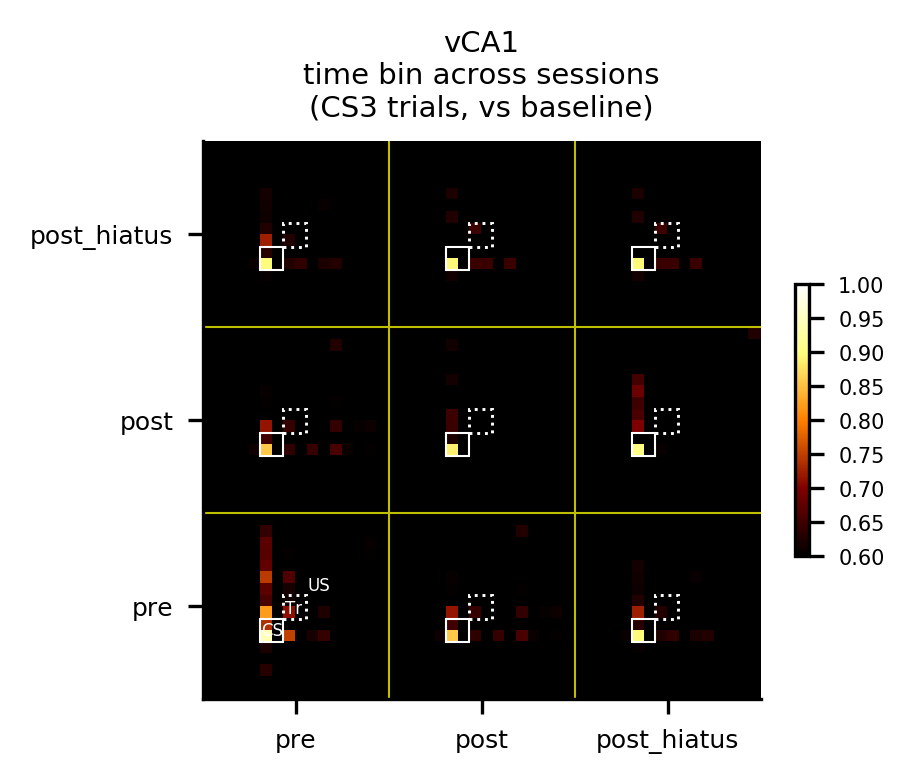

In [148]:
CS = 'CS3'
fig,ax = pl.subplots(1,figsize=(3,3))
im = ax.pcolormesh(eval("mega_distinct_means_all_1s_%s"%(CS)),vmin=0.6, vmax=1,cmap='afmhot')
pl.axis('image')
ticks = [8,24,40]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(['pre','post','post_hiatus'],fontsize=6)
ax.set_yticklabels(['pre','post','post_hiatus'],fontsize=6)
pl.hlines([16,32],-0.5,80,color='y')
pl.vlines([16,32],-0.5,80,color='y')
pl.title('vCA1\ntime bin across sessions\n(%s trials, vs baseline)'%CS)

import matplotlib.patches as patches
# Create a Rectangle patch
for i in range(5):
    CS1 = patches.Rectangle((i*16+4.9,4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    CS2 = patches.Rectangle((i*16+4.9,1*16+4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    CS3 = patches.Rectangle((i*16+4.9,2*16+4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    Tr1 = patches.Rectangle((i*16+6.9,6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
    Tr2 = patches.Rectangle((i*16+6.9,1*16+6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
    Tr3 = patches.Rectangle((i*16+6.9,2*16+6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax.add_patch(CS1)
    ax.add_patch(CS2)
    ax.add_patch(CS3)
    ax.add_patch(Tr1)
    ax.add_patch(Tr2)
    ax.add_patch(Tr3)
pl.text(5,5.45,"CS",fontsize=4, color='w')
pl.text(7.1,7.35,"Tr",fontsize=4, color='w')
pl.text(9,9.35,"US",fontsize=4, color='w')
#cax = fig.add_axes([.85, 0.86, 0.05, 0.05])
fig.colorbar(im,shrink=0.4)

fig.savefig('../figures/%s_MEGA_MATRIX_%s.pdf'%(NOTEBOOK_NAME,CS))

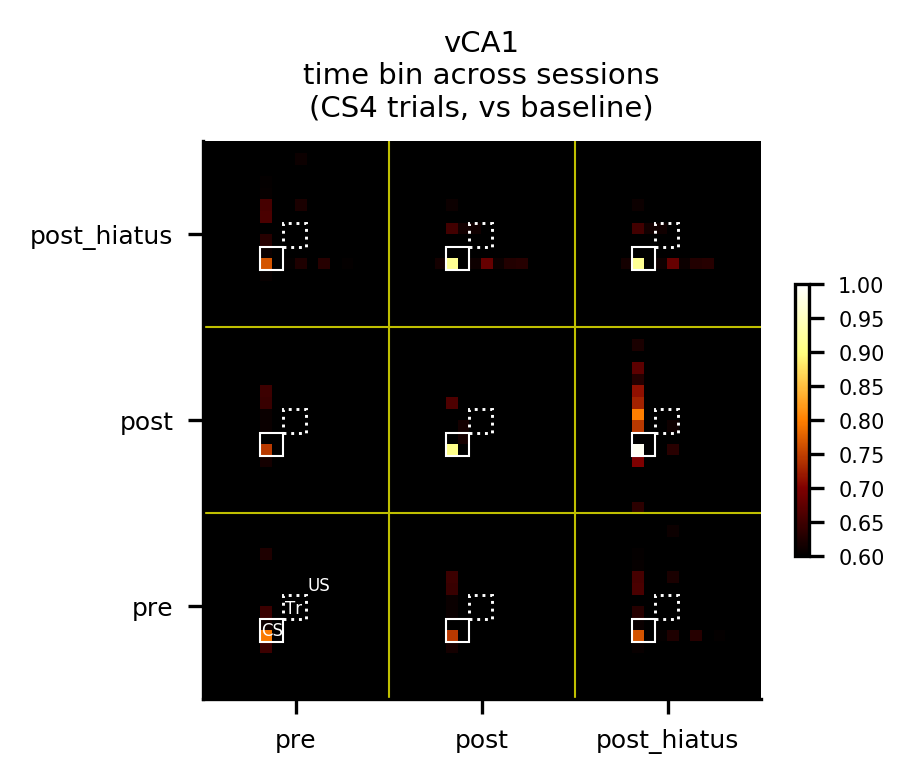

In [149]:
CS = 'CS4'
fig,ax = pl.subplots(1,figsize=(3,3))
im = ax.pcolormesh(eval("mega_distinct_means_all_1s_%s"%(CS)),vmin=0.6, vmax=1,cmap='afmhot')
pl.axis('image')
ticks = [8,24,40]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(['pre','post','post_hiatus'],fontsize=6)
ax.set_yticklabels(['pre','post','post_hiatus'],fontsize=6)
pl.hlines([16,32],-0.5,80,color='y')
pl.vlines([16,32],-0.5,80,color='y')
pl.title('vCA1\ntime bin across sessions\n(%s trials, vs baseline)'%CS)

import matplotlib.patches as patches
# Create a Rectangle patch
for i in range(5):
    CS1 = patches.Rectangle((i*16+4.9,4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    CS2 = patches.Rectangle((i*16+4.9,1*16+4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    CS3 = patches.Rectangle((i*16+4.9,2*16+4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    Tr1 = patches.Rectangle((i*16+6.9,6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
    Tr2 = patches.Rectangle((i*16+6.9,1*16+6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
    Tr3 = patches.Rectangle((i*16+6.9,2*16+6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax.add_patch(CS1)
    ax.add_patch(CS2)
    ax.add_patch(CS3)
    ax.add_patch(Tr1)
    ax.add_patch(Tr2)
    ax.add_patch(Tr3)
pl.text(5,5.45,"CS",fontsize=4, color='w')
pl.text(7.1,7.35,"Tr",fontsize=4, color='w')
pl.text(9,9.35,"US",fontsize=4, color='w')
#cax = fig.add_axes([.85, 0.86, 0.05, 0.05])
fig.colorbar(im,shrink=0.4)

fig.savefig('../figures/%s_MEGA_MATRIX_%s.pdf'%(NOTEBOOK_NAME,CS))

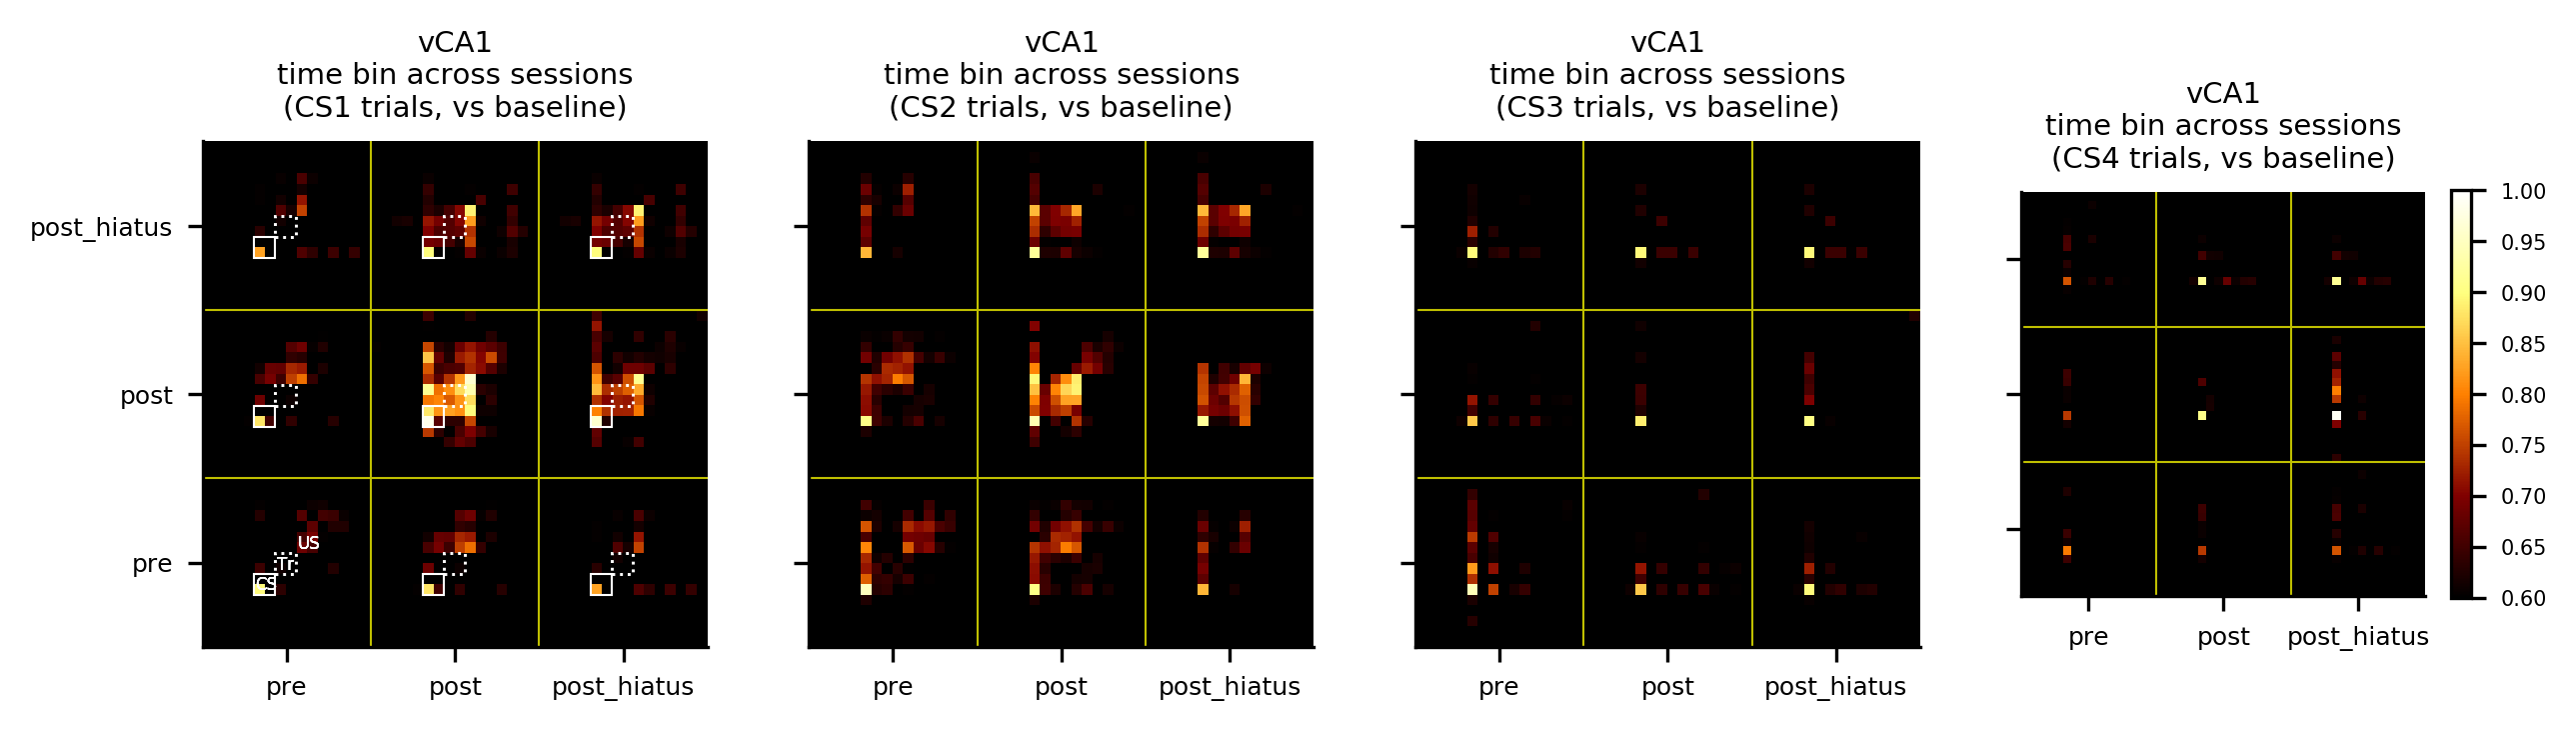

In [186]:
fig,ax = pl.subplots(1,4,figsize=(10,3))
for x,CS in zip(range(4),['CS1','CS2','CS3','CS4']):
    im = ax[x].pcolormesh(eval("mega_distinct_means_all_1s_%s"%(CS)),vmin=0.6, vmax=1,cmap='afmhot')
    ax[x].axis('image')
    ticks = [8,24,40]
    ax[x].set_xticks(ticks)
    ax[x].set_yticks(ticks)
    ax[x].set_xticklabels(['pre','post','post_hiatus'],fontsize=6)
    ax[0].set_yticklabels(['pre','post','post_hiatus'],fontsize=6)
    ax[x].set_yticklabels(['','',''])
    ax[x].hlines([16,32],-0.5,80,color='y')
    ax[x].vlines([16,32],-0.5,80,color='y')
    ax[x].set_title('vCA1\ntime bin across sessions\n(%s trials, vs baseline)'%CS)
    
import matplotlib.patches as patches
# Create a Rectangle patch
for i in range(5):
    CS1 = patches.Rectangle((i*16+4.9,4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    CS2 = patches.Rectangle((i*16+4.9,1*16+4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    CS3 = patches.Rectangle((i*16+4.9,2*16+4.9),2,2,linewidth=.5,edgecolor='w',facecolor='none')
    Tr1 = patches.Rectangle((i*16+6.9,6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
    Tr2 = patches.Rectangle((i*16+6.9,1*16+6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
    Tr3 = patches.Rectangle((i*16+6.9,2*16+6.9),2,2,linewidth=.7,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[0].add_patch(CS1)
    ax[0].add_patch(CS2)
    ax[0].add_patch(CS3)
    ax[0].add_patch(Tr1)
    ax[0].add_patch(Tr2)
    ax[0].add_patch(Tr3)
    ax[0].text(5,5.45,"CS",fontsize=4, color='w')
    ax[0].text(7.1,7.35,"Tr",fontsize=4, color='w')
    ax[0].text(9,9.35,"US",fontsize=4, color='w')
#cax = fig.add_axes([.85, 0.86, 0.05, 0.05])
fig.colorbar(im,shrink=0.6)

#fig.savefig('../figures/%s_MEGA_MATRIX_%s.pdf'%(NOTEBOOK_NAME,CS))

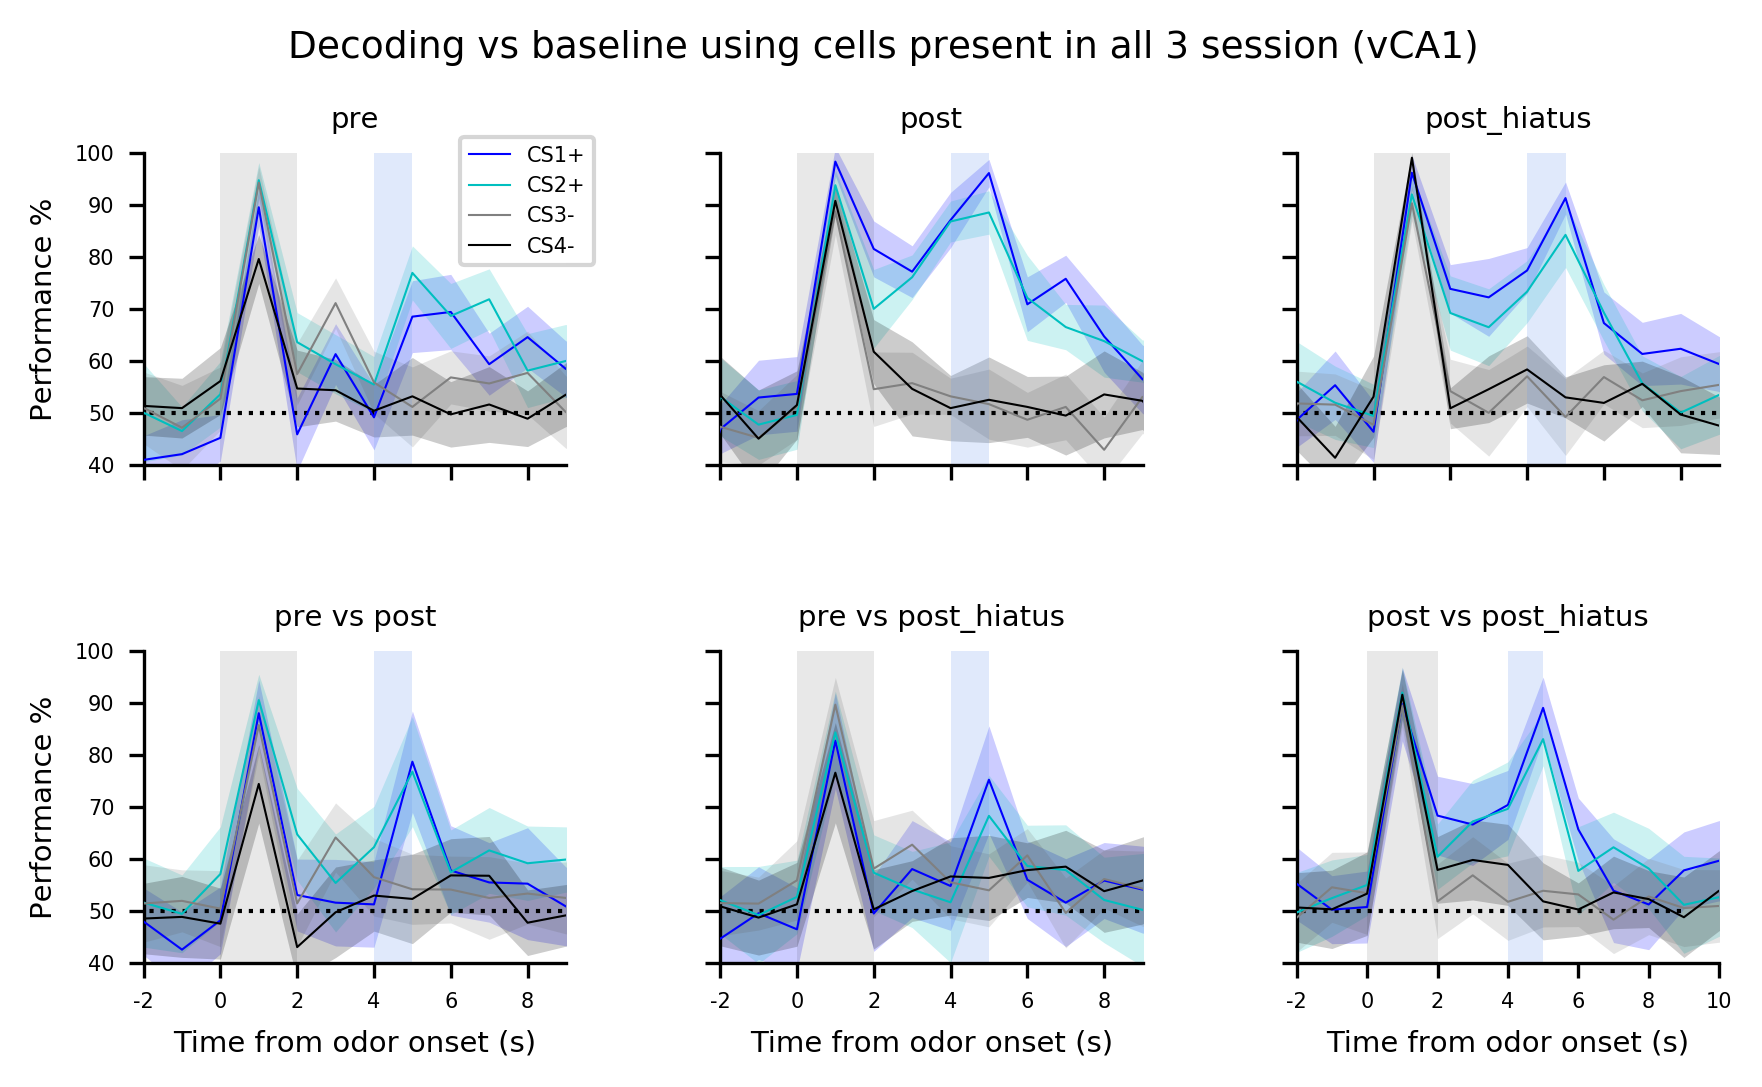

In [187]:
fig, ax = pl.subplots(2,3, figsize=(6.5, 4), sharex=True, sharey=True)

for comp,c,la in zip(comparison_labels,['b','c','grey','k'],['CS1+','CS2+','CS3-','CS4-']):
    for i,cr in zip(range(3),CR_comparisons):
        ax[1][i].plot([(t-4) for t in range(16)], [(np.mean(eval("baseline_scores_1s_%svs%s_reg_w_all_%s_tb%svs%s"%(cr[0],cr[1],
                    comp,t,t)))*100) for t in range(16)],color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("baseline_scores_1s_%svs%s_reg_w_all_%s_tb%svs%s"%(cr[0],cr[1],
                    comp,t,t)))*100) for t in range(16)])
        s = np.array([np.std(eval("baseline_scores_1s_%svs%s_reg_w_all_%s_tb%svs%s"%(cr[0],cr[1],
                    comp,t,t)))*100 for t in range(16)])
        ax[1][i].fill_between([(t-4) for t in range(16)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        ax[1][i].set_title('%s vs %s'%(cr[0],cr[1]))
        
    for i,sess in zip(range(3),sessions[1:]):
        ax[0][i].plot([(t-4) for t in range(16)], [(np.mean(eval("baseline_scores_1s_%s_reg_w_all_%s_tb%svs%s"%(sess,comp,t,t)))*100) for t in range(16)],color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("baseline_scores_1s_%s_reg_w_all_%s_tb%svs%s"%(sess,comp,t,t)))*100) for t in range(16)])
        s = np.array([np.std(eval("baseline_scores_1s_%s_reg_w_all_%s_tb%svs%s"%(sess,comp,t,t)))*100 for t in range(16)])
        ax[0][i].fill_between([(t-4) for t in range(16)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        ax[0][i].set_title(sess)
        
for x in range(2):
    for y in range(3):
        ax[x][y].set_ylim(40, 100)
        ax[x][y].set_xlim(-2, 9)
        ax[x][y].set_xticks(np.arange(-2,11, 2))
        ax[x][y].set_xticklabels(np.arange(-2,11, 2))
        ax[x][y].hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
        ax[1][y].set_xlabel('Time from odor onset (s)')
        ax[x][0].set_ylabel('Performance %')
        pt.plot_period_bar(ax[x][y], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[x][y], 0, start_end=(4, 5), color='cornflowerblue', delta_y=100, alpha=.2)
ax[0][0].legend(bbox_to_anchor=(.75, 1.05), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline using cells present in all 3 session (vCA1)", fontsize=9, y=.96)

fig.tight_layout(pad=3)

#fig.savefig('../img/%s_3comp_horizontal.jpg'%NOTEBOOK_NAME)

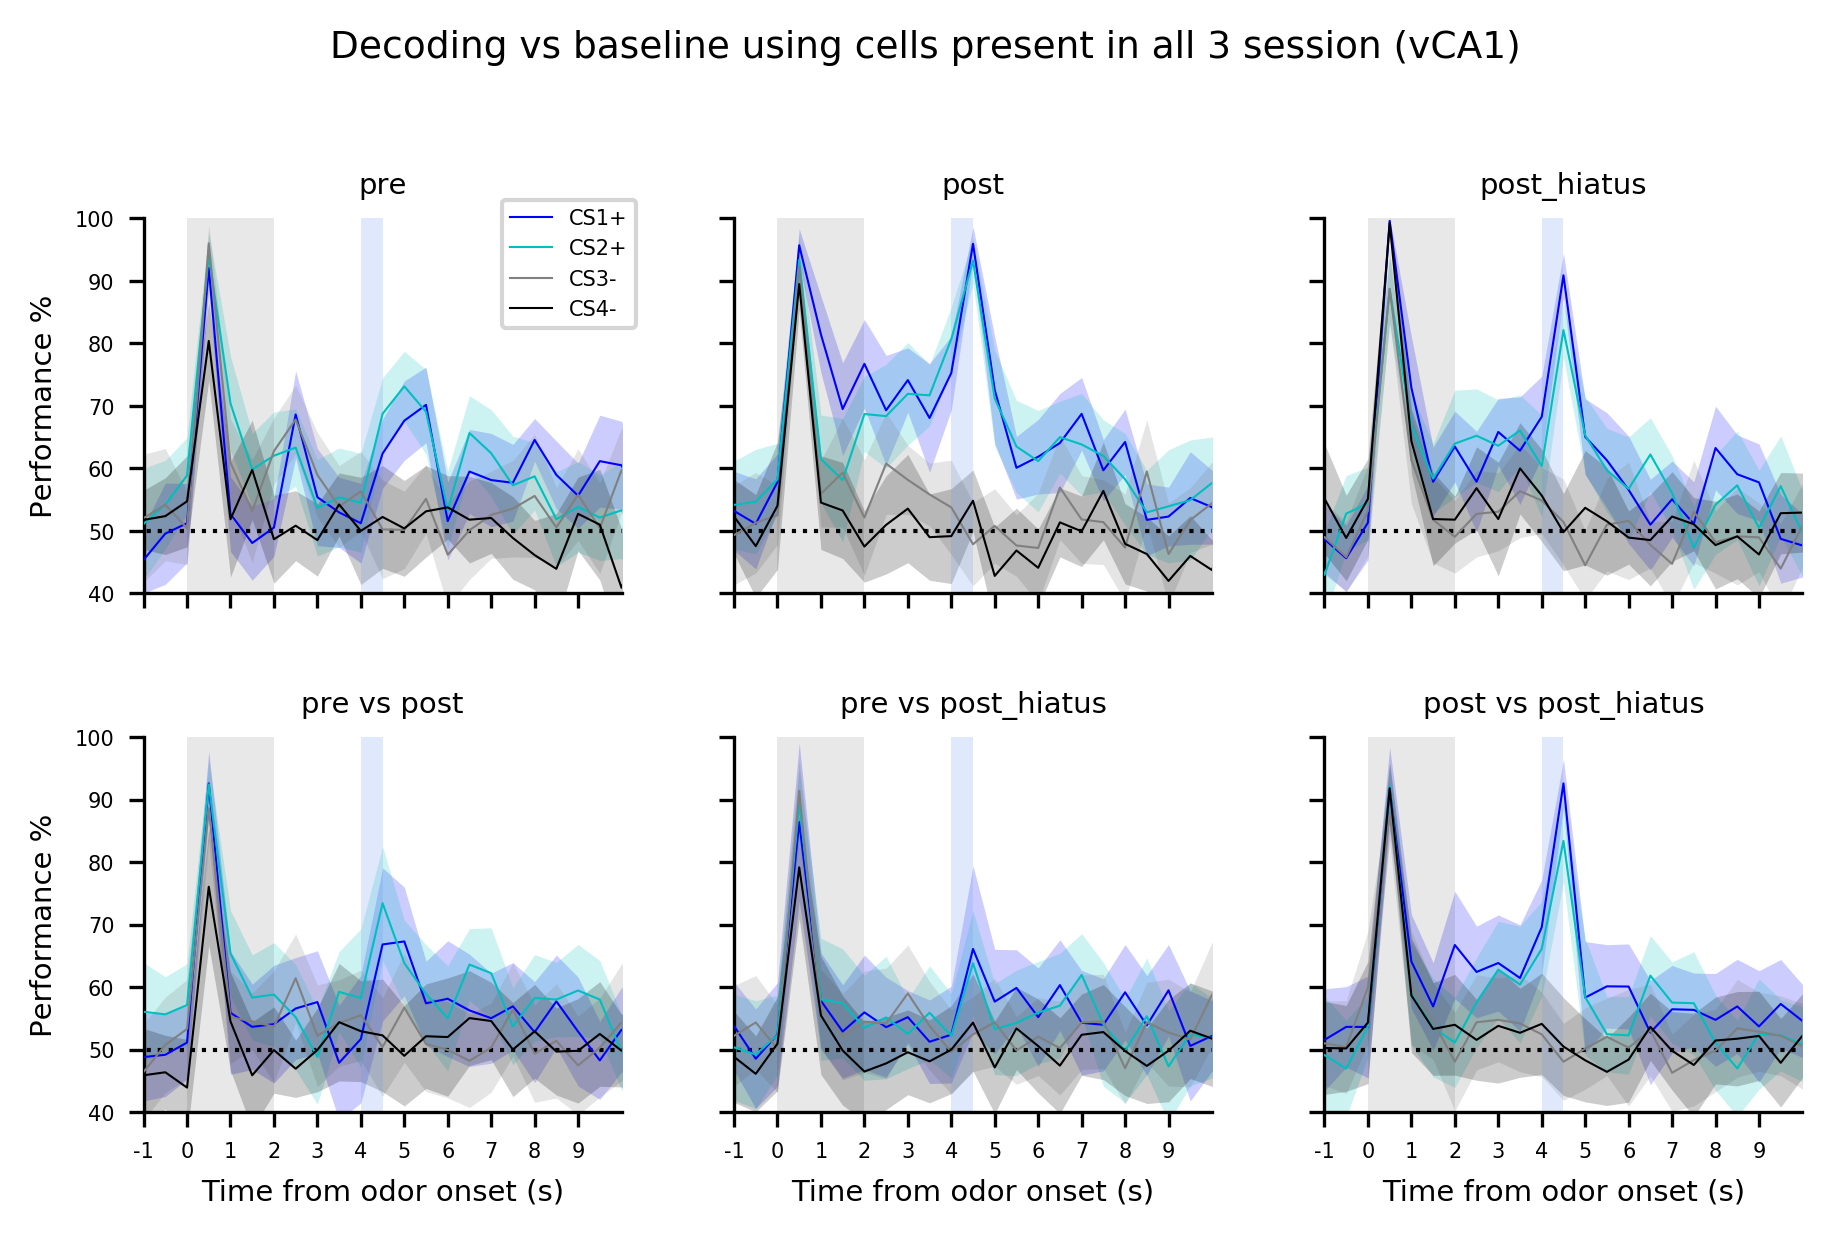

In [180]:
fig, ax = pl.subplots(2,3, figsize=(6.5, 4), sharex=True, sharey=True)

for comp,c,la in zip(comparison_labels,['b','c','grey','k'],['CS1+','CS2+','CS3-','CS4-']):
    for i,sess in zip(range(3),sessions[1:]):
        ax[0][i].plot([(t-10) for t in range(32)], [(np.mean(eval("baseline_scores_05s_%s_reg_w_all_%s_tb%svs%s"%(sess,comp,t,t)))*100) for t in range(32)],color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("baseline_scores_05s_%s_reg_w_all_%s_tb%svs%s"%(sess,comp,t,t)))*100) for t in range(32)])
        s = np.array([np.std(eval("baseline_scores_05s_%s_reg_w_all_%s_tb%svs%s"%(sess,comp,t,t)))*100 for t in range(32)])
        ax[0][i].fill_between([(t-10) for t in range(32)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        ax[0][i].set_title(sess)
        
    for i,cr in zip(range(3),CR_comparisons):
        ax[1][i].plot([(t-10) for t in range(32)], [(np.mean(eval("baseline_scores_05s_%svs%s_reg_w_all_%s_tb%svs%s"%(cr[0],cr[1],
                    comp,t,t)))*100) for t in range(32)],color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("baseline_scores_05s_%svs%s_reg_w_all_%s_tb%svs%s"%(cr[0],cr[1],
                    comp,t,t)))*100) for t in range(32)])
        s = np.array([np.std(eval("baseline_scores_05s_%svs%s_reg_w_all_%s_tb%svs%s"%(cr[0],cr[1],
                    comp,t,t)))*100 for t in range(32)])
        ax[1][i].fill_between([(t-10) for t in range(32)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
        ax[1][i].set_title('%s vs %s'%(cr[0],cr[1]))
        
for x in range(2):
    for y in range(3):
        ax[x][y].set_ylim(40, 100)
        ax[x][y].set_xlim(-2, 20)
        ax[x][y].set_xticks(np.arange(-2,20, 2))
        ax[x][y].set_xticklabels(np.arange(-1,20,1))
        ax[x][y].hlines(50, -10,22, color='k', lw=1, linestyles='dotted')
        ax[1][y].set_xlabel('Time from odor onset (s)')
        ax[x][0].set_ylabel('Performance %')
        pt.plot_period_bar(ax[x][y], 0, start_end=(0, 4), color='k', delta_y=100,alpha=.09)
        pt.plot_period_bar(ax[x][y], 0, start_end=(8, 9), color='cornflowerblue', delta_y=100, alpha=.2)
ax[0][0].legend(bbox_to_anchor=(.75, 1.05), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline using cells present in all 3 session (vCA1)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

#fig.savefig('../img/%s_3comp_horizontal.jpg'%NOTEBOOK_NAME)

In [181]:
save_workspace(db)

Could not store variable 'im'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'Tr2'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'CS4'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'CS5'. Skipping...
Could not store variable 'CS1'. Skipping...
Could not store variable 'Tr1'. Skipping...
Could not store variable 'Tr3'. Skipping...
Could not store variable 'Tr5'. Skipping...
Could not store variable 'Tr4'. Skipping...
Could not store variable 'patches'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'CS3'. Skipping...
Could not store variable 'CS2'. Skipping...
